# VGG16
VGG16 ist ein vortrainiertes CNN, welches mit dem ImageNet Datensatz trainiert wurde. 
Um ein besseres Verständnis des Models zu bekommen, wird es hier von Grund auf neu implementiert und auf den mnist-Datensatz angewendet. 

In [10]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.cmap'] = 'Greys'

import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)

In [11]:
# Loading the data (MNIST)
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [3]:
print (mnist.train.images.shape)
print (mnist.train.labels.shape)

(55000, 784)
(55000,)


In [4]:
print (mnist.test.images.shape)
print (mnist.test.labels.shape)

(10000, 784)
(10000,)


3


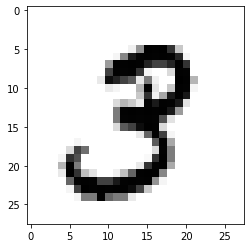

In [5]:
example_image = mnist.train.images[1]
example_image_reshaped = example_image.reshape((28, 28)) # Can't render a line of 784 numbers
example_label = mnist.train.labels[1]

print (example_label)
plt.imshow(example_image_reshaped)

Die Architektur des Modells ist hier zu sehen:

<img src="images/vgg-architecture.png">

Das hier implementierte Modell ist das VGG16-D, welche eine gute Performance zeigt. 
Nun wollen wir uns die Architekur etwas genauer anschauen:
VGG16-D besteht aus 16 Schichten. Die input-Bilder haben eine größe von 224x224 Pixeln. 
Jeder "Convolutional Layer" (conv3-64), hat die Kernelgröße 3x3 und 64 "channels".
Der stride und padding sind 1 für die "Convolutional Layers".
Es werden ebenfalls 5 MaxPoolings durchgeführt.
Diese haben eine größe von 2x2 und ein stride von 2.
Es folgen zwei "Fully-Connected Leyer" mit jeweils 4092 Neuronen. 
Und zum Schluss die softmax-Klassifizierung.
Die verwendete Aktivierungsfunktion ist ReLU.

Im folgenden wird diese Architekur implementiert:

In [6]:
def cnn_model_fn(features, labels, mode):
    # Input Layer
    input_height, input_width = 28, 28
    input_channels = 1
    input_layer = tf.reshape(features["x"], [-1, input_height, input_width, input_channels])

    # Convolutional Layer #1 and Pooling Layer #1
    conv1_1 = tf.layers.conv2d(inputs=input_layer, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv1_2 = tf.layers.conv2d(inputs=conv1_1, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1_2, pool_size=[2, 2], strides=2, padding="same")
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2_1 = tf.layers.conv2d(inputs=pool1, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv2_2 = tf.layers.conv2d(inputs=conv2_1, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2_2, pool_size=[2, 2], strides=2, padding="same")

    # Convolutional Layer #3 and Pooling Layer #3
    conv3_1 = tf.layers.conv2d(inputs=pool2, filters=256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv3_2 = tf.layers.conv2d(inputs=conv3_1, filters=256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv3_3 = tf.layers.conv2d(inputs=conv3_2, filters=256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3_3, pool_size=[2, 2], strides=2, padding="same")

    # Convolutional Layer #4 and Pooling Layer #4
    conv4_1 = tf.layers.conv2d(inputs=pool3, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv4_2 = tf.layers.conv2d(inputs=conv4_1, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
  #  conv4_3 = tf.layers.conv2d(inputs=conv4_2, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool4 = tf.layers.max_pooling2d(inputs=conv4_2, pool_size=[2, 2], strides=2, padding="same")

    # Convolutional Layer #5 and Pooling Layer #5
    conv5_1 = tf.layers.conv2d(inputs=pool4, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv5_2 = tf.layers.conv2d(inputs=conv5_1, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
   # conv5_3 = tf.layers.conv2d(inputs=conv5_2, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool5 = tf.layers.max_pooling2d(inputs=conv5_2, pool_size=[2, 2], strides=2, padding="same")

    # FC Layers
    pool5_flat = tf.contrib.layers.flatten(pool5)
    FC1 = tf.layers.dense(inputs=pool5_flat, units=4096, activation=tf.nn.relu)
    FC2 = tf.layers.dense(inputs=FC1, units=4096, activation=tf.nn.relu)
    FC3 = tf.layers.dense(inputs=FC2, units=1000, activation=tf.nn.relu)

    """the training argument takes a boolean specifying whether or not the model is currently 
    being run in training mode; dropout will only be performed if training is true. here, 
    we check if the mode passed to our model function cnn_model_fn is train mode. """
    dropout = tf.layers.dropout(inputs=FC3, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits Layer or the output layer. which will return the raw values for our predictions.
    # Like FC layer, logits layer is another dense layer. We leave the activation function empty 
    # so we can apply the softmax
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    # Then we make predictions based on raw output
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        # the predicted class for each example - a vlaue from 0-9
        "classes": tf.argmax(input=logits, axis=1),
        # to calculate the probablities for each target class we use the softmax
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels,
                                        predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode,
                                      loss=loss,
eval_metric_ops=eval_metric_ops)

In [7]:
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/mnist_vgg16_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_vgg16_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff8f6570e80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Der mnist-Datensatz stellt sich als kein guter dar. Da tiefe Neuronale Netze sich als nicht effizient für kleine Bilder herausgestellt haben. Das die Bilder die größe 28x28 haben und außerdem noch fünf MaxPools durchgeführt werden, in welchen die Bilder jeweils auf die hälfte ihrer größen komprimiert werden, sind diese nicht mehr aussagekräftig.

In [8]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": train_data},
                                                        y=train_labels,
                                                        batch_size=100,
                                                        num_epochs=100, shuffle=True)

In [9]:
mnist_classifier.train(input_fn=train_input_fn, steps=None, hooks=None)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipeline

KeyboardInterrupt: 

In [ ]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": eval_data},
                                                   y=eval_labels,
                                                   num_epochs=1,
                                                   shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)